# Tratamento 

### Importações

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
np.random.seed(241098)
sns.set()
sns.set(rc={'figure.figsize':(10,6)})

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import  RepeatedStratifiedKFold

### Apendice:
    Ponto de partida, um modelo de DummyClassifier, utilizando a estratefia de mais frequente.

    Refinamento:
        Exclusão das altas correlações (+0.95), assim baixando o numero de features utilizados, de 229 para 98.
        
    Testes (Modelos):
        Arvore
        Regressão Logistica
        Floresta 1
        Floresta 2
        Floresta 3

### Modelo Dummy


In [4]:
# Leitura dos dados salvos com a biblioteca Pickle
with open('data_pick', 'rb') as pickle_file:
    dados_para_dummy_classifier = pickle.load(pickle_file)

O ponto de partida será um modelo com o DummyClassifier, com a estrategia do valor mais frequente.

In [5]:
y = dados_para_dummy_classifier["ICU"]
x = dados_para_dummy_classifier.drop(["ICU"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo_dummy = DummyClassifier(strategy='most_frequent' )
modelo_dummy.fit(x_train, y_train)

y_prediction = modelo_dummy.predict(x_test)

print("Acerto:",accuracy_score(y_test, y_prediction)*100)

Acerto: 53.40909090909091


## Refinamentos

Com o objetivo de refinar nosso modelo, vou comecar removendo as colunas com correlação muito alta(+0.95)

In [6]:

def correlacao(dados, pctcorr):
     lista_colunas_altas= set()
     matrix_correlacao = dados.iloc[:,10:-1].corr().abs()
     for i in range(len(matrix_correlacao.columns)):
          for j in range(i):
               if (matrix_correlacao.iloc[i,j]) > pctcorr:
                    nome_col = matrix_correlacao.columns[i]
                    lista_colunas_altas.add(nome_col)
     return lista_colunas_altas
correlacao(dados_para_dummy_classifier, 0.95)

colunas_para_remover = correlacao(dados_para_dummy_classifier, 0.95)
dados_finais = dados_para_dummy_classifier.drop(colunas_para_remover, axis=1)

O dataset passou de 229 para 98 colunas

## Testes

####  Como metrica final será considerada os Falsos negativos, onde no nosso cenario corresponderia a pessas que precisam de UTI e foram diagnosticadas com Não precisantes

              precision    recall  f1-score   support

           0       0.64      0.87      0.74        47
           1       0.75      0.44      0.55        41

    accuracy                           0.67        88
   macro avg       0.70      0.66      0.65        88
weighted avg       0.69      0.67      0.65        88



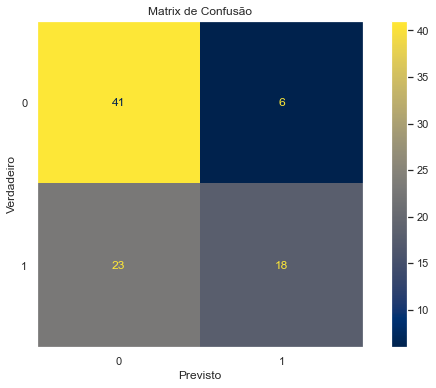

In [34]:
# Arvore de decisão:
def arvore(dados):
    np.random.seed(241098)

    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=0)
    modelo_arvore = DecisionTreeClassifier(random_state=0, max_depth=2)
    modelo_arvore.fit(x_train, y_train)
    y_pred_arvore = modelo_arvore.predict(x_test)

    cm = confusion_matrix(y_test, y_pred_arvore)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
    disp.plot(cmap='cividis')
    print(classification_report(y_test, y_pred_arvore))
    plt.grid(False)
    plt.title('Matrix de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()

arvore(dados_finais) 

Uma primeira arvore, a qual possui um resultado catastrofico.
Teriam 23 pacientes que precisam de UTI mandados para casa.

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        47
           1       0.80      0.80      0.80        41

    accuracy                           0.82        88
   macro avg       0.82      0.82      0.82        88
weighted avg       0.82      0.82      0.82        88



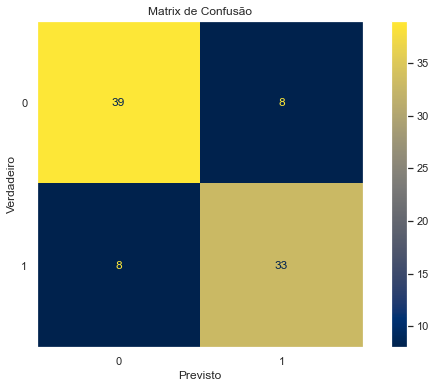

Media da validação cruzada: 0.7704063213931636


In [33]:
# Modelo de Regressão Logistica:
def regressao_logistica(dados):
    np.random.seed(241098)

    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y,test_size=0.25, random_state=0)
    modelo_rl = LogisticRegression(random_state=0)
    modelo_rl.fit(x_train, y_train)
    y_pred = modelo_rl.predict(x_test)
    
    cvv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=10 )
    resultados = cross_validate(modelo_rl, x, y, cv =cvv, scoring='roc_auc')
    media_cross = np.mean(resultados['test_score'])
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='cividis')
    print(classification_report(y_test, y_pred))
    plt.grid(False)
    plt.title('Matrix de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()

    print('Media da validação cruzada:',media_cross)

regressao_logistica(dados_finais)

A Regressão Logistica foi muito melhor que a arvore simples tanto em todo classification_report, mas também nos Falsos Negativos

A seguir contém varias tentativas de um RandomForestClassifier o qual eu espera que fosse performar melhor que a regressão logistica, porém nas minhas 3 tentativas isso não ocorreu. Nem o classification_report, como um resultado de Falsos Negativos conseguiram superar a Regressão Logistica. Que acabou sendo o modelo escolhido!

              precision    recall  f1-score   support

           0       0.79      0.81      0.80        47
           1       0.78      0.76      0.77        41

    accuracy                           0.78        88
   macro avg       0.78      0.78      0.78        88
weighted avg       0.78      0.78      0.78        88



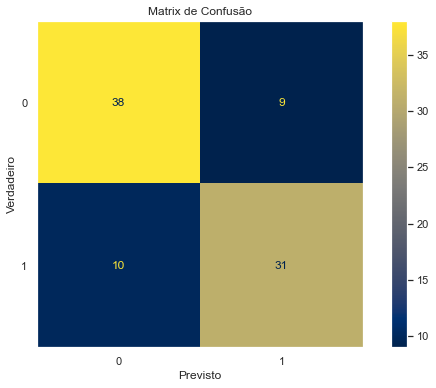

In [36]:
# Minha primeira floresta basica
def floresta(dados, estimator):
    np.random.seed(241098)

    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=0)
    modelo_floresta = RandomForestClassifier(n_estimators=estimator, random_state=0)
    modelo_floresta.fit(x_train, y_train)
    y_pred = modelo_floresta.predict(x_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='cividis')
    print(classification_report(y_test, y_pred))
    plt.grid(False)
    plt.title('Matrix de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()

    
floresta(dados_finais, 40)




              precision    recall  f1-score   support

           0       0.79      0.81      0.80        47
           1       0.78      0.76      0.77        41

    accuracy                           0.78        88
   macro avg       0.78      0.78      0.78        88
weighted avg       0.78      0.78      0.78        88



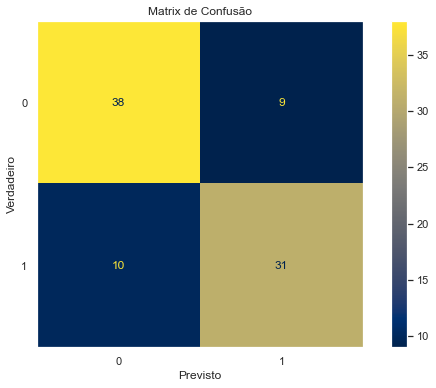

Media da calidação cruzada:  0.7907001109961636


In [38]:
# Minha segunda floresta com RepeatedStratifiedKFold e um numero de 40 arvores

def floresta(dados, estimator):
    np.random.seed(241098)

    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=0)
    modelo_floresta = RandomForestClassifier(n_estimators=estimator, random_state=0)
    modelo_floresta.fit(x_train, y_train)
    y_pred = modelo_floresta.predict(x_test)
    
    cvv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=10 )
    resultados = cross_validate(modelo_floresta, x, y, cv =cvv, scoring='roc_auc')

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='cividis')
    print(classification_report(y_test, y_pred))
    plt.grid(False)
    plt.title('Matrix de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()

    media_cross = np.mean(resultados['test_score'])
    print('Media da calidação cruzada: ',media_cross)
    # return print('Media da validação cruzada:',media_cross), plot_confusion_matrix(modelo_floresta, x_test, y_test), print(classification_report(y_test, y_pred))

floresta(dados_finais, 40)




              precision    recall  f1-score   support

           0       0.81      0.81      0.81        47
           1       0.78      0.78      0.78        41

    accuracy                           0.80        88
   macro avg       0.79      0.79      0.79        88
weighted avg       0.80      0.80      0.80        88



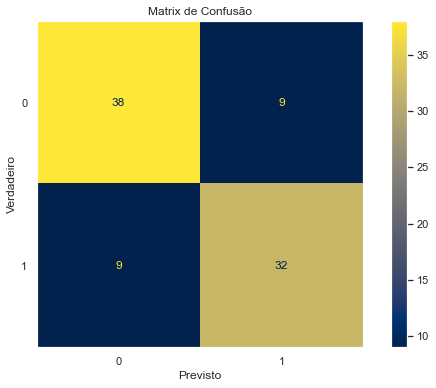

Media da validação cruzada(roc_auc):  0.7986157875046764


In [39]:
# Minha terceira floresta com StratifiedKFold e um numero de 400 arvores

def floresta(dados, estimator):
    np.random.seed(241098)

    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=0)
    modelo_floresta = RandomForestClassifier(n_estimators=estimator, random_state=0)
    modelo_floresta.fit(x_train, y_train)
    y_pred = modelo_floresta.predict(x_test)
    
    
    cv = StratifiedKFold(n_splits = 3, shuffle=True)
    resultados = cross_validate(modelo_floresta, x, y, cv =cv, scoring='roc_auc')
    media_cross = np.mean(resultados['test_score'])
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='cividis')
    print(classification_report(y_test, y_pred))
    plt.grid(False)
    plt.title('Matrix de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show() 
    print('Media da validação cruzada(roc_auc): ',media_cross)

floresta(dados_finais, 400)   

Sendo este ultimo modelo de floresta o que mais se aproximou da Regressão Logistica

### Conclusões

In [45]:
data = [{'Falso Negativos': 23, 'Verdadeiro Positivos': 18, 'F1-Score': 0.67}, {'Falso Negativos': 8, 'Verdadeiro Positivos': 33, 'F1-Score': 0.81 , 'Roc_Auc': 0.770}, {'Falso Negativos': 10, 'Verdadeiro Positivos': 31, 'F1-Score': 0.78},{'Falso Negativos': 10, 'Verdadeiro Positivos': 31, 'F1-Score': 0.78 , 'Roc_Auc': 0.790},{'Falso Negativos': 9, 'Verdadeiro Positivos': 32, 'F1-Score': 0.80, 'Roc_Auc': 0.798}]
datas= pd.DataFrame(data, index =['Árvore', 'Regressão', 'Floresta_1', 'Floresta_2', 'Floresta_3'])

datas.style.highlight_min(subset=['Falso Negativos'], 
props='background-color: lightgray; color: royalblue').highlight_max(subset=['Falso Negativos'], 
props='background-color: lightgray; color: lightcoral').highlight_min(subset=['Verdadeiro Positivos'], 
props='background-color: lightgray; color: lightcoral').highlight_max(subset=['Verdadeiro Positivos'],
props='background-color: lightgray; color: royalblue').highlight_min(subset=['F1-Score'], 
props='background-color: lightgray; color: lightcoral').highlight_max(subset=['F1-Score'],
props='background-color: lightgray; color: royalblue').highlight_min(subset=['Roc_Auc'], 
props='background-color: lightgray; color: lightcoral').highlight_max(subset=['Roc_Auc'],
props='background-color: lightgray; color: royalblue')
# O codigo aqui esta identado desta forma exotica, com a finalidade de poder encolher as linhas de codigo.

,Falso Negativos,Verdadeiro Positivos,F1-Score,Roc_Auc
Árvore,23,18,0.670000,nan
Regressão,8,33,0.810000,0.770000
Floresta_1,10,31,0.780000,nan
Floresta_2,10,31,0.780000,0.790000
Floresta_3,9,32,0.800000,0.798000


O modelo de Regressão Logistica, foi escolhido com os seguintes criterios, maior precisão(F1-Score) e também pelas resultados da matrix de confusão. Que considerando nosso problema "Saber se o paciente precisa ser internado ou não", o pior problema seria mandar um paciente que precisa ser internado para casa, como o resultado desse modelo teve o menor numero de Falsos Negativos foi o escolhido. E tambem sendo ele o com maior numero de verdadeiros positivos. Apesar de ser o com o menor valor de Curva Auc.

#### Trabalhos futuros
    Criar modelos utilizando os algoritimos de KNN, Naive Bays e SVM.